In [44]:
# Read result files

import pickle
import os
from collections import Iterable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()
plt.rcParams.update({'font.size': 22})

In [2]:
def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:        
            yield item
            
def find(lst, s):
    return [i for i, x in enumerate(lst) if x==s]

def keys_exists(element, *keys):
    '''
    Check if *keys (nested) exists in `element` (dict).
    '''
    if not isinstance(element, dict):
        raise AttributeError('keys_exists() expects dict as first argument.')
    if len(keys) == 0:
        raise AttributeError('keys_exists() expects at least two arguments, one given.')

    _element = element
    for key in keys:
        try:
            _element = _element[key]
        except KeyError:
            return False
    return True

In [3]:
dataset = 'prison'

In [4]:
results_dict={}

In [5]:
for file in os.listdir('./results_prison'):
    with open(f'./results_prison/{file}', 'rb') as handle:
        flatten_file_name = list(flatten([i.split('.') for i in file.split('_')]))
        idx_dataset_name = find(flatten_file_name, dataset)[0]
        sample = flatten_file_name[idx_dataset_name+1:-1][-1]
        version = flatten_file_name[idx_dataset_name+1:-1][-2]
        transformation = '_'.join(flatten_file_name[idx_dataset_name+1:-1][:-2])
        if not keys_exists(results_dict, transformation):
            results_dict[transformation] = {}
        if not keys_exists(results_dict, transformation, version): 
            results_dict[transformation][version] = {}
        if not keys_exists(results_dict, transformation, version, sample):    
            results_dict[transformation][version][sample] = {}

        results_dict[transformation][version][sample] = pickle.load(handle)

In [6]:
# shape=(transformation, version, sample, metric, dim)
# metric = mase, rmse
# dim = bottom, total, state, gender, legal, all

df = pd.DataFrame.from_dict({(i,j, k, l): results_dict[i][j][k][l] 
                           for i in results_dict.keys() 
                           for j in results_dict[i].keys()
                           for k in results_dict[i][j].keys()
                           for l in results_dict[i][j][k].keys()},
                       orient='index')

In [21]:
df_mase = df[np.in1d(df.index.get_level_values(3), ['mase'])]

In [22]:
df_clean = df_mase.mean(level=(0,1,2)).stack(level=0).to_frame()

In [23]:
df_clean = df_clean.reset_index()

In [24]:
df_clean.columns = ['transformation', 'version', 'sample', 'group', 'mase']

In [25]:
#fg = sns.catplot(x='version', y='val', hue='group', kind="point", dodge=True,
#                        col='transformation',col_wrap=2, data=df_clean.sort_values('version'))
#fg.set_xlabels('');

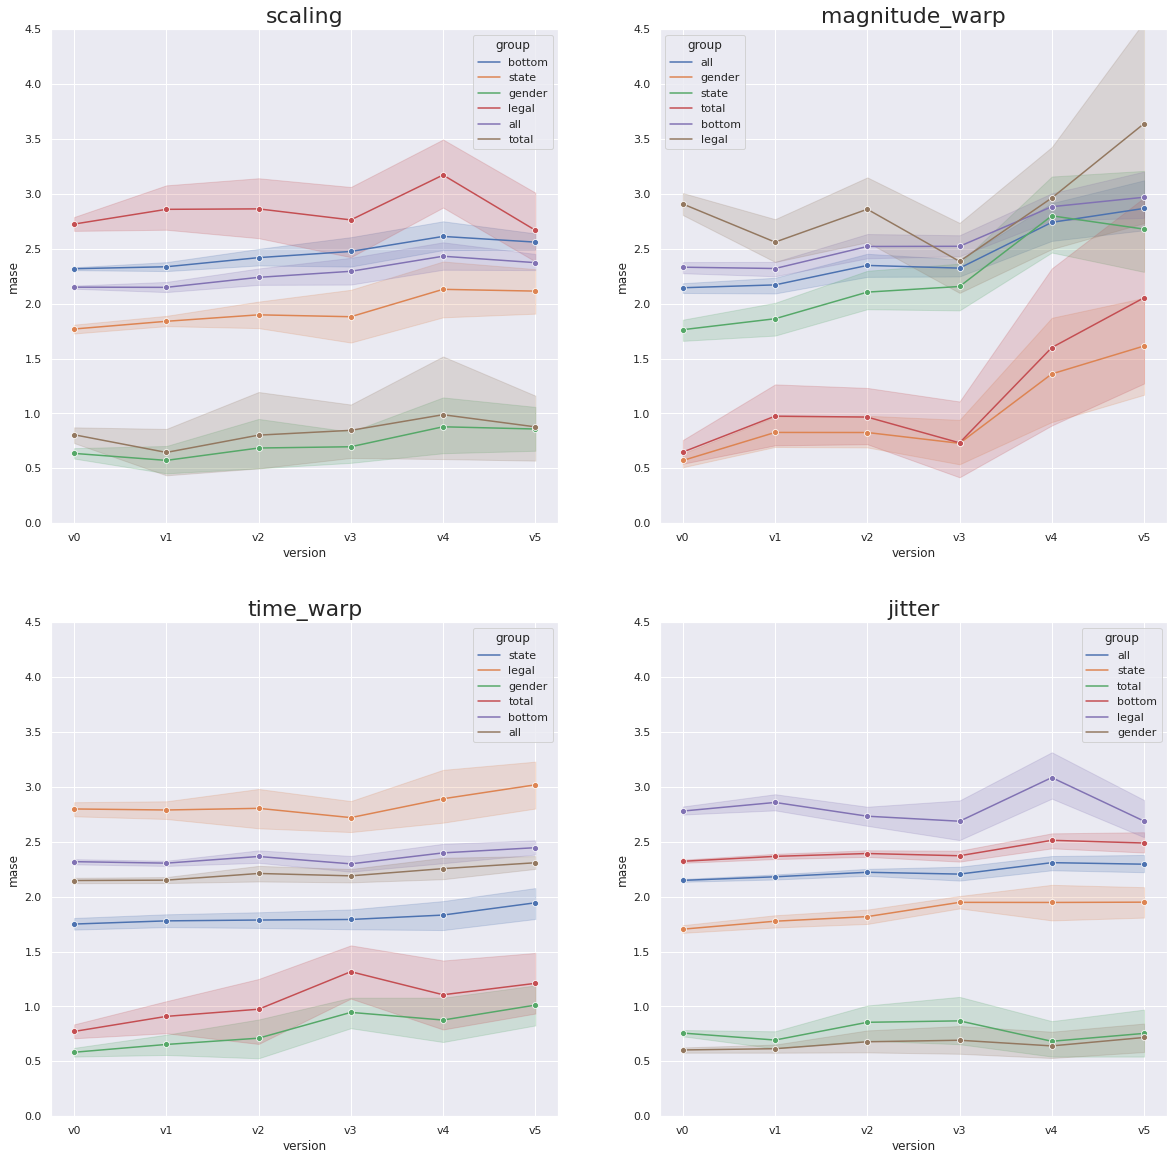

In [51]:
_, ax = plt.subplots(2, 2, figsize=(20, 20))
ax = ax.ravel()
transf = df_clean.transformation.unique()
for i in range(len(transf)):
    fg = sns.lineplot(x='version', y='mase', hue='group', marker='o', data=df_clean.loc[df_clean['transformation']==transf[i]].sort_values('version'), ax=ax[i])
    ax[i].set_ylim(0, 4.5)
    ax[i].set_title(transf[i], fontsize=22)